<a href="https://colab.research.google.com/github/subir7/tfproject/blob/main/Final_image_captioning_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#!pip install -q 'tensorflow-text==2.11.*'
#!pip install -q tensorflow_datasets
!pip install -q einops

In [218]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import collections
import time
import string
import re
import einops
from tqdm.auto import tqdm
from PIL import Image
import nltk
from nltk.util import ngrams
import math
from ultralytics import YOLO
import cv2

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()
#import tensorflow_text as tf_text
#import tensorflow_datasets as tfds

from yolo_extraction import yolo8_bounding_boxes_with_distance
from emotion_img import emotion_img

In [219]:
print(tf.__version__)

2.10.1


In [220]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
nltk.download('punkt_tab')
#nltk.download('punkt')

[nltk_data] Error loading punkt_tab: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


False

In [221]:
def get_data(path = 'flickr8k'):
    path = pathlib.Path('flickr8k')

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

    tf.keras.utils.get_file(origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                            cache_dir = '.',
                            cache_subdir = path,
                            extract = True)

def get_dataset(path = 'flickr8k'):
    path = pathlib.Path('.')
    captions = (path/'Flickr8k_text/Flickr8k.token.txt').read_text().splitlines()
    captions = [cap.split('\t') for cap in captions]
    captions = [(img_path.split('#')[0], cap) for (img_path, cap) in captions]
    cap_dict = collections.defaultdict(list)
    for img_path, cap in captions:
        cap_dict[img_path].append(cap)

    train_imgs_path = (path/'Flickr8k_text/Flickr_8k.trainImages.txt').read_text().splitlines()
    test_imgs_path = (path/'Flickr8k_text/Flickr_8k.testImages.txt').read_text().splitlines()

    train_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in train_imgs_path]
    test_caps = [(str(path/'Flicker8k_Dataset'/img_path), cap_dict[img_path]) for img_path in test_imgs_path]

    #train_raw = tf.data.experimental.from_list(train_caps[:500])
    #test_raw = tf.data.experimental.from_list(test_caps[:100])

    train_raw = tf.data.experimental.from_list(train_caps)
    test_raw = tf.data.experimental.from_list(test_caps)

    return train_raw, test_raw

In [222]:
#get_data()
train_raw, test_raw = get_dataset()

In [223]:
print(len(train_raw), len(test_raw))
print(train_raw.element_spec)

for img_path, captions in train_raw.take(1):
    break

print(img_path)
print(captions)

6000 1000
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.string, name=None))
tf.Tensor(b'Flicker8k_Dataset\\2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor([b'A black dog is running after a white dog in the snow .' b'Black dog chasing brown dog through snow' b'Two dogs chase each other across the snowy ground .' b'Two dogs play together in the snow .' b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


In [224]:
#image_shape = (224, 224, 3)
#feature_extractor = tf.keras.applications.MobileNetV3Small(input_shape = image_shape, include_preprocessing = True, include_top = False)
#feature_extractor = tf.keras.applications.InceptionV3(input_shape = image_shape, include_top=False, weights='imagenet')
#feature_extractor.trainable = False

# Remove any np_config.enable_numpy_behavior() lines if they exist
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

try:
    image_shape = (224, 224, 3)
    feature_extractor = tf.keras.applications.MobileNetV3Small(
        input_shape=image_shape,
        include_preprocessing=True,
        include_top=False
    )
    #feature_extractor = tf.keras.applications.InceptionV3(input_shape = image_shape, include_top=False, weights='imagenet')
    print("MobileNetV3Small model created successfully!")
    feature_extractor.trainable = False
    print(f"Model output shape: {feature_extractor.output_shape}")
except Exception as e:
    print(f"Error creating MobileNetV3Small model: {e}")

MobileNetV3Small model created successfully!
Model output shape: (None, 7, 7, 576)


In [225]:
# Example of how to load a saved tokenizer (if you saved it as a pickle)
try:
    with open('tokenizer.pkl', 'rb') as handle:
        text_emotion_tokenizer = pickle.load(handle)
except FileNotFoundError:
    print("WARNING: text_emotion_tokenizer.pkl not found. Please ensure your tokenizer is saved and loaded correctly.")

try:
    with open('./label_encoder.pkl', 'rb') as handle:
        text_emotion_label_encoder = pickle.load(handle)
except FileNotFoundError:
    print("WARNING: label_encoder.pkl not found. Please ensure your label_encoder is saved and loaded correctly.")
    text_emotion_label_encoder = LabelEncoder()
    text_emotion_label_encoder.fit(['sad', 'angry', 'surprise', 'fear', 'happy', 'neutral',
       'disgust/worry/hate'])

def predict_emotion_text(captions_txt):
  # First, handle the input which is now definitively a tf.Tensor
    if isinstance(captions_txt, tf.Tensor):
        # Convert the tf.Tensor (bytes) to a NumPy array (bytes)
        captions_numpy_array = captions_txt.numpy()
    elif isinstance(captions_txt, np.ndarray):
        # If it happens to be a NumPy array (e.g., during direct testing)
        captions_numpy_array = captions_txt
    else:
        raise TypeError(f"Unexpected input type for captions: {type(captions_txt)}. Expected tf.Tensor or np.ndarray.")

    # NOW, iterate over the elements of captions_numpy_array
    # Assuming captions_numpy_array contains byte strings (from tf.string)
    decoded_txt = []
    for byte_string_element in captions_numpy_array.flatten(): # .flatten() ensures 1D iteration
        # This is the correct way to convert each byte string element to a Python str
        python_str_element = byte_string_element.decode('utf-8')
        decoded_txt.append(python_str_element)

    emotion_txt_model = tf.keras.models.load_model('Emotion_Analysis_Text.h5')
    # Show the model architecture
    #emotion_txt_model.summary()
    
    #print("================================")
    #text = text.numpy().decode('utf-8')
    decoded_txt = "".join(decoded_txt) #decoded_txt.item().decode('utf-8')
    #[captions_numpy_array.item().decode('utf-8')]
    #print(decoded_txt)
    #decoded_txt = "b'A black dog is running after a white dog in the snow .' b'Black dog chasing brown dog through snow' b'Two dogs chase each other across the snowy ground .' b'Two dogs play together in the snow .' b'Two dogs running through a low lying body of water"
    # tokenize and pad the review
    sequence = text_emotion_tokenizer.texts_to_sequences([decoded_txt])
    padded_sequence = pad_sequences(sequence, maxlen=50)
    prediction = emotion_txt_model.predict(padded_sequence)
    predicted_key = np.argmax(prediction, axis=1)[0]
    #print(predicted_key)
    #return np.full((1, 1, 576), predicted_key, dtype=np.float32)
    return predicted_key
    #text_emotion_label_encoder.inverse_transform(a)[0]

In [226]:
def process_yolo(img_feature, yolo_features, emotion_txt, emotion_image) :
    #emotion_image = np.full((1, 1, 576), emotion_image, dtype=np.float32)
    yolo_features = np.array(yolo_features.numpy().flatten())
    emotion_txt = np.array(emotion_txt.numpy().flatten())
    emotion_image = np.array(emotion_image.numpy().flatten())
    #yolo_features = yolo_features.numpy().flatten()
    yolo_features = np.pad(yolo_features, (0, 576 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)
    emotion_txt = np.pad(emotion_txt, (0, 576 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)
    emotion_image = np.pad(emotion_image, (0, 576 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)
    #yolo_features = np.pad(yolo_features, ((0, img_new.shape[0] - yolo_features.shape[0]), (0, img_new.shape[1] - yolo_features.shape[1])), mode='constant', constant_values=0)
    
    yolo_features = yolo_features.reshape((1, 1, 576))
    emotion_txt = np.full((576,), emotion_txt, dtype=np.float32)
    emotion_txt = emotion_txt.reshape((1, 1, 576))
    emotion_image = np.full((576,), emotion_image, dtype=np.float32)
    emotion_image = emotion_image.reshape((1, 1, 576))

    #print(img_feature.shape)
    img_feature = tf.reshape(img_feature, (tf.shape(yolo_features)[0], -1, 576))
    img_feature = img_feature[:, :47, :] # This is your (1, 47, 576) tensor
    #print(img_feature.shape)


    #print(yolo_features.shape)
    #print(emotion_txt.shape)
    #print(emotion_image.shape)
    # Concatenate tensors along the last axis
    combined_features = np.concatenate((img_feature, yolo_features, emotion_txt, emotion_image), axis=-2)
    #combined_features = np.concatenate((img_feature, yolo_features), axis=-2)
    print(combined_features.shape)
    return combined_features

def load_img(img_path, captions):
    #print(img_path)
    #print(captions)
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    #print(img.shape)
    img = tf.image.resize(img, image_shape[:-1])
    img = tf.expand_dims(img, axis=0)
    #print(img.shape)
    img = feature_extractor(img)
    #print(img.shape)
    img_feature = tf.reshape(img,(img.shape[0], -1, img.shape[3]))
    #print(img_feature.shape) 
    #yolo_features = yolo8_bounding_boxes_with_distancex(img_path)
    yolo_features = tf.py_function(yolo8_bounding_boxes_with_distance, [img_path], tf.float32)
    #print(type(yolo_features))
    #print(yolo_features.numpy())
    emotion_txt = tf.py_function(predict_emotion_text, [captions], tf.float32)
    emotion_image = tf.py_function(emotion_img, [img_path], tf.float32)
    
    yolo_features = tf.py_function(process_yolo, [img_feature, yolo_features, emotion_txt, emotion_image], tf.float32)
    #yolo_features = np.array(yolo_features.numpy().flatten())
    #yolo_features = yolo_features.numpy().flatten()
    #yolo_features = np.pad(yolo_features, (0, 576 - yolo_features.shape[0]), 'constant', constant_values=(0, 0)).astype(np.float32)
    #yolo_features = np.pad(yolo_features, ((0, img_new.shape[0] - yolo_features.shape[0]), (0, img_new.shape[1] - yolo_features.shape[1])), mode='constant', constant_values=0)
    #yolo_features = yolo_features.reshape((1, 1, 576))


    
    # Concatenate tensors along the last axis
    #combined_features = np.concatenate((img_feature, yolo_features), axis=-2)
    #yolo_features = np.expand_dims(yolo_features, axis=0)
    #print("YOLO FEATURES ARE :: ", yolo_features.shape)
    #print("NUMPY FEATURES ARE :: ", bf.numpy().shape)
    #combined_features = np.vstack((img_feature, yolo_features)).astype(np.float32)
    #combined_features = np.concatenate((img_new, yolo_features), axis=1)
    #print("COMBINED FEATURES ARE :: ", yolo_features.shape)
    #yolo_features = tf.reshape(yolo_features, ( 50, 576))
    yolo_features = tf.reshape(yolo_features, ( 10, 5, 576))
    #print("FINAL COMBINED FEATURES ARE :: ", yolo_features.shape)
    return yolo_features

In [227]:
def textprocess(captions_input):
  # First, handle the input which is now definitively a tf.Tensor
    if isinstance(captions_input, tf.Tensor):
        # Convert the tf.Tensor (bytes) to a NumPy array (bytes)
        captions_numpy_array = captions_input.numpy()
    elif isinstance(captions_input, np.ndarray):
        # If it happens to be a NumPy array (e.g., during direct testing)
        captions_numpy_array = captions_input
    else:
        raise TypeError(f"Unexpected input type for captions: {type(captions_input)}. Expected tf.Tensor or np.ndarray.")

    # NOW, iterate over the elements of captions_numpy_array
    # Assuming captions_numpy_array contains byte strings (from tf.string)
    decoded_texts = []
    for byte_string_element in captions_numpy_array.flatten(): # .flatten() ensures 1D iteration
        # This is the correct way to convert each byte string element to a Python str
        python_str_element = byte_string_element.decode('utf-8')
        decoded_texts.append(python_str_element)

    #print("".join(decoded_texts))
    return "".join(decoded_texts)

In [228]:
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()

img = load_img(img_path.numpy().decode('utf-8'), captions)
print(img.shape)
#print(feature_extractor(img[tf.newaxis, ...]).shape)


0: 512x640 2 dogs, 326.4ms
Speed: 3.7ms preprocess, 326.4ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 640)
1/1 [==============================] - 0s 268ms/step

0: 512x640 (no detections), 327.5ms
Speed: 2.8ms preprocess, 327.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)
Results saved to caption\img703
(1, 50, 576)
(10, 5, 576)


In [229]:
'''
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

img_path, img_name_val, captions, cap_val = train_test_split(img_path,
                                                                    captions,
                                                                    test_size=0.4,
                                                                    random_state=0)
len(img_path), len(captions), len(img_name_val), len(cap_val)
'''

'\nfrom sklearn.utils import shuffle\nfrom sklearn.model_selection import train_test_split\n\nimg_path, img_name_val, captions, cap_val = train_test_split(img_path,\n                                                                    captions,\n                                                                    test_size=0.4,\n                                                                    random_state=0)\nlen(img_path), len(captions), len(img_name_val), len(cap_val)\n'

In [230]:
import numpy as np

# Example tensors
tensor1 = np.random.rand(1, 49, 576)
tensor2 = np.random.rand(576,)

# Reshape tensor2 to have a shape of (1, 1, 576)
tensor2_reshaped = tensor2.reshape((1, 1, 576))

# Concatenate tensors along the last axis
result = np.concatenate((tensor1, tensor2_reshaped), axis=-2)

print("Shape of tensor1:", tensor1.shape)
print("Shape of tensor2_reshaped:", tensor2_reshaped.shape)
print("Shape of concatenated tensor:", result.shape)


Shape of tensor1: (1, 49, 576)
Shape of tensor2_reshaped: (1, 1, 576)
Shape of concatenated tensor: (1, 50, 576)


In [231]:
def standardize(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, f'[{re.escape(string.punctuation)}]', '')
    text = tf.strings.join(['[START]',text,'[END]'], separator = ' ')
    return text

In [232]:
standardize('A black dog is running after a white dog in the snow .')

<tf.Tensor: shape=(), dtype=string, numpy=b'[START] a black dog is running after a white dog in the snow  [END]'>

In [233]:
vocab_size = 3000
vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                               standardize = standardize,
                                               ragged = True)

vectorizer.adapt(train_raw.map(lambda img_path, cap: cap).unbatch().batch(1024))

In [234]:
print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']


In [235]:
text_to_id_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '')
id_to_text_vectorizer = tf.keras.layers.StringLookup(vocabulary = vectorizer.get_vocabulary(), mask_token = '', invert = True)

In [236]:
def id_to_text(token_ids, reserved_tokens = ['', '[UNK]', '[START]', '[END]']):
    words = id_to_text_vectorizer(token_ids)
    bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != '[UNK]']
    bad_tokens_re = '|'.join(bad_tokens)
    bad_mask = tf.strings.regex_full_match(words, bad_tokens_re)
    words = tf.ragged.boolean_mask(words, ~bad_mask)

    return tf.strings.reduce_join(words, axis = -1, separator = ' ')

def serialize_data(images, captions):
    captions_shape = einops.parse_shape(captions, 'b c')
    captions = einops.rearrange(captions, 'b c -> (b c)')
    images = einops.repeat(images, 'b ...  -> (b c) ...', c = captions_shape['c'])
    return images, captions

In [237]:
for img, cap in train_raw.batch(1024).take(1):
    break

print(img.shape)
print(cap.shape)
img_serialize, cap_serialize = serialize_data(img, cap)
print(img_serialize.shape, cap_serialize.shape)

(1024,)
(1024, 5)
(5120,) (5120,)


In [238]:
def prepare_batch(img, cap):
    cap_tokenized = vectorizer(cap)
    cap_tokenized_in = cap_tokenized[:, :-1]
    cap_tokenized_out = cap_tokenized[:, 1:]
    #print("cap_tokenized_in", cap_tokenized_in)
    #print("cap_tokenized_out", cap_tokenized_out)

    return (img, cap_tokenized_in.to_tensor()), cap_tokenized_out.to_tensor()

In [239]:
def save_dataset(raw_ds, file_path, image_feature_extractor, vectorizer, shards = 20, batch_size = 8):
    raw_ds = (raw_ds
              .map(lambda img_path, cap: (load_img(img_path, cap), cap), tf.data.AUTOTUNE)
              #.map(lambda img_path, cap: (img_path, cap), tf.data.AUTOTUNE)
              .batch(batch_size))

    def gen():
        for (img, cap) in tqdm(raw_ds):
            print("##################", img.shape)
            print(raw_ds)
            #img_features = image_feature_extractor(img)
            #img_features = image_feature_extractor(img)
            #yolo_features = yolo8_bounding_boxes_with_distancex(img)
            #print(yolo_features)
            img_features, cap = serialize_data(img, cap)

            yield img_features, cap

    ds = tf.data.Dataset.from_generator(gen,
                                        output_signature = (
                                            #tf.TensorSpec(shape = image_feature_extractor.output_shape),
                                            tf.TensorSpec(shape = (None, 10, 5, 576)),
                                            tf.TensorSpec(shape = (None,), dtype = tf.string)
                                        ))

    ds = (ds
          .map(prepare_batch, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(1000))

    def shard_func(i, data):
        return i % shards

    ds.enumerate().save(file_path, shard_func = shard_func)

#save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

In [240]:
%%time
#save_dataset(train_raw, 'train_cache', feature_extractor, vectorizer)
#save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)
#!zip -r '/content/test_cache.zip' '/content/test_cache'

#from google.colab import files
#files.download('test_cache.zip')

CPU times: total: 0 ns
Wall time: 0 ns


In [241]:
#save_dataset(test_raw, 'test_cache', feature_extractor, vectorizer)

In [242]:
feature_extractor.output_shape

(None, 7, 7, 576)

In [243]:
def load_dataset(file_path, batch_size = 8, cycle_length = 2):
    def reader_func(ds):
        ds = ds.shuffle(1000)
        return ds.interleave(lambda x: x, cycle_length = cycle_length)

    def drop_index(i, x):
        return x

    ds = tf.data.Dataset.load(file_path, reader_func = reader_func)

    ds = (ds
          .map(drop_index)
          .shuffle(1000)
          .padded_batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [244]:
batch_size = 8
train_ds = load_dataset('train_cachex', batch_size)
test_ds = load_dataset('test_cachex', batch_size)

In [245]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

print(cap[0])
print(cap_labels[0])

(8, 10, 5, 576)
(8, 23)
(8, 23)
tf.Tensor([   3    2   17  125  407   47    2  964  797   11   14   59 2361    0    0    0    0    0    0    0    0    0    0], shape=(23,), dtype=int64)
tf.Tensor([   2   17  125  407   47    2  964  797   11   14   59 2361    4    0    0    0    0    0    0    0    0    0    0], shape=(23,), dtype=int64)


In [246]:
train_ds.element_spec

((TensorSpec(shape=(None, 10, 5, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [247]:
def positional_encoding(length, depth):
    pos = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
    dep = tf.cast(tf.range(depth)[tf.newaxis, :], tf.float32)
    dep = ((dep // 2)*2)/tf.cast(depth, tf.float32)

    angle_rates = 1 / (10000**dep)
    angle_rads = pos*angle_rates

    out = tf.Variable(tf.zeros((length, depth)))
    out[:, 0::2].assign(tf.math.sin(angle_rads[:, 0::2]))
    out[:, 1::2].assign(tf.math.cos(angle_rads[:, 1::2]))

    return out[tf.newaxis, ...]

In [248]:
sample_enc = positional_encoding(length = 2048, depth = 512)[0]

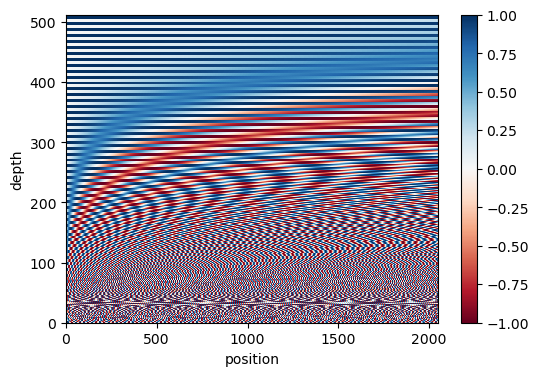

In [249]:
plt.figure(figsize = (6, 4))
plt.pcolormesh(tf.transpose(sample_enc), cmap = 'RdBu')
plt.xlabel('position')
plt.ylabel('depth')
plt.colorbar()
plt.show();

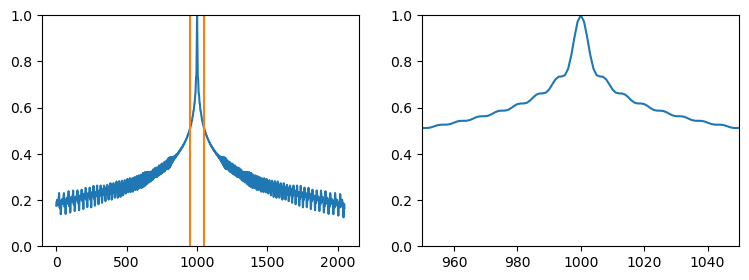

In [250]:
p_norm = tf.linalg.l2_normalize(sample_enc[1000][tf.newaxis, :])
sample_enc_norm = tf.linalg.l2_normalize(sample_enc, axis = 1)
dots = tf.linalg.matmul(sample_enc_norm, p_norm, transpose_b = True)

plt.figure(figsize = (9, 3))
plt.subplot(1, 2, 1)
plt.plot(dots)
plt.ylim([0, 1])
plt.plot([950, 950, float('nan'), 1050, 1050], [0, 1, float('nan'), 0, 1])

plt.subplot(1, 2, 2)
plt.plot(dots)
plt.ylim([0, 1])
plt.xlim([950, 1050])
plt.show()

In [251]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero = True)
        self.pos_enc = positional_encoding(length = 2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x_emb = self.embedding(x)
        x_pos_enc = self.pos_enc[:, :length, :]

        x_emb *= tf.cast(self.d_model, tf.float32)
        x_emb += x_pos_enc

        return x_emb

In [252]:
sample_pos_emb = PositionalEmbedding(vocab_size, d_model = 512)
cap_emb = sample_pos_emb(cap)
print(cap_emb.shape)

(8, 23, 512)


In [253]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

In [254]:
class CausalAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(query = x,
                               key = x,
                               value = x,
                               use_causal_mask = True)

        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [255]:
sample_csa = CausalAttention(num_heads = 8, key_dim = 512)
sample_csa_out = sample_csa(cap_emb)
print(sample_csa_out.shape)

(8, 23, 512)


In [256]:
class CrossAttention(BaseAttention):
    def call(self, context, x):
        attn_out, attn_scores = self.mha(query = x,
                                         key = context,
                                         value = context,
                                         return_attention_scores = True)

        self.last_attention_scores = attn_scores

        x = self.add([x, attn_out])
        x = self.layernorm(x)
        return x

In [257]:
# Assuming img is your input tensor with shape (8, 50, 576)
#img_ = tf.expand_dims(img, axis=0)
#img_ = einops.rearrange(img, 'b h w -> b (h w) c')
#img = tf.reshape(img, (8, 5, 10, 576))
img_ = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img.shape, img_.shape)

sample_ca = CrossAttention(num_heads = 8, key_dim = 512)
sample_ca_out = sample_ca(context = img_, x = sample_csa_out)
print(sample_ca_out.shape)

(8, 10, 5, 576) (8, 50, 576)
(8, 23, 512)


In [258]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation = 'relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(rate = dropout_rate)
        ])

        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        return x

In [259]:
sample_ffn = FeedForward(d_model = 512, dff = 2048)
sample_ffn_out = sample_ffn(sample_ca_out)
print(sample_ffn_out.shape)

(8, 23, 512)


In [260]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(num_heads = num_heads,
                                                key_dim = d_model,
                                                dropout = dropout_rate)
        self.cross_attention = CrossAttention(num_heads = num_heads,
                                              key_dim = d_model,
                                              dropout = dropout_rate)
        self.ffn = FeedForward(d_model = d_model,
                               dff = dff,
                               dropout_rate = dropout_rate)
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.causal_attention(x)
        x = self.cross_attention(context = context, x = x)
        x = self.ffn(x)
        self.last_attention_scores = self.cross_attention.last_attention_scores

        return x

In [261]:
sample_decoder_layer = DecoderLayer(d_model = 512, dff = 2048, num_heads = 8, dropout_rate = 0.2)
sample_decoder_layer_out = sample_decoder_layer(context = img_, x = cap_emb)
print(sample_decoder_layer_out.shape)

(8, 23, 512)


In [262]:
class OutputLayer(tf.keras.layers.Layer):
    def __init__(self, vocab, bad_tokens = ('', '[UNK]', '[START]')):
        super().__init__()
        self.vocab = vocab
        self.bad_tokens = bad_tokens
        self.bias = 0
        self.dense_layer = tf.keras.layers.Dense(len(vocab), activation = tf.nn.log_softmax)

    def adapt(self, cap_ds):
        word_idx = {word : idx for idx, word in enumerate(self.vocab)}
        counts = collections.Counter()
        for tokens in cap_ds:
            counts.update(tokens.numpy().flatten())

        counts_arr = np.zeros((len(self.vocab), ))
        for token_id, cnt in counts.items():
            counts_arr[token_id] = cnt

        bad_indices = np.array([word_idx[word] for word in self.bad_tokens])
        counts_arr[bad_indices] = 0

        counts_prob = counts_arr / counts_arr.sum()
        counts_prob[counts_arr == 0] = 1
        log_p = np.log(counts_prob)

        entropy = (-counts_prob*log_p).sum()

        print(f'uniform_entropy : {np.log(len(self.vocab))}')
        print(f'curr_entropy : {entropy}')
        log_p[counts_arr == 0] = -1e9

        self.bias = log_p[tf.newaxis, tf.newaxis, :]

    def call(self, x):
        return self.dense_layer(x) + self.bias

In [263]:
vocab = vectorizer.get_vocabulary()
sample_output_layer = OutputLayer(vocab)
sample_output_layer.adapt(train_ds.map(lambda img, cap: cap))
sample_output_layer_out = sample_output_layer(sample_decoder_layer_out)
print(sample_output_layer_out.shape)

uniform_entropy : 8.006367567650246
curr_entropy : 5.124592119957593
(8, 23, 3000)


In [264]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_heads, d_model, dff, dropout_rate = 0.1):
        super().__init__()
        self.num_layers = num_layers

        self.positional_embedding = PositionalEmbedding(vocab_size, d_model)
        self.decoder_layers = [DecoderLayer(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)]
        self.last_attention_scores = None

    def call(self, context, x):
        x = self.positional_embedding(x)
        for i in range(self.num_layers):
            x = self.decoder_layers[i](context = context, x = x)

        self.last_attention_scores = self.decoder_layers[-1].last_attention_scores
        return x

In [265]:
for (img, cap), cap_labels in train_ds.take(1):
    break

print(img.shape)
print(cap.shape)
print(cap_labels.shape)

#img = tf.reshape(img, (8, 5, 10, 576))
img_features = einops.rearrange(img, 'b h w c -> b (h w) c')
print(img_features.shape)

(8, 10, 5, 576)
(8, 22)
(8, 22)
(8, 50, 576)


In [266]:
%%time
sample_decoder = Decoder(num_layers = 6, num_heads = 8, d_model = 512, dff = 2048)
sample_decoder_output = sample_decoder(context = img_features, x = cap)
print(sample_decoder_output.shape)
print(sample_decoder.last_attention_scores.shape)

(8, 22, 512)
(8, 8, 22, 50)
CPU times: total: 859 ms
Wall time: 781 ms


In [267]:
class Captioner(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, vectorizer, feature_extractor, output_layer, num_layers, num_heads, d_model, dff, pred_max_len =  50, dropout_rate = 0.1):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.vectorizer = vectorizer
        self.output_layer = output_layer
        self.decoder = Decoder(num_layers, num_heads, d_model, dff, dropout_rate)
        self.max_len = pred_max_len
        self.vocab = self.vectorizer.get_vocabulary()

    def call(self, inputs):
        context, cap = inputs
        print("###", context.shape)
        print("###", context.shape[-1])
        if context.shape[-1] == 3:
            context = self.feature_extractor(context)
        context = einops.rearrange(context, 'b h w c -> b (h w) c')

        if cap.dtype == tf.string:
            cap = self.vectorizer([cap])


        x = self.decoder(context = context, x = cap)
        x = self.output_layer(x)
        return x

In [268]:
%%time
sample_captioner = Captioner(vectorizer = vectorizer,
                             feature_extractor = feature_extractor,
                             output_layer = sample_output_layer,
                             num_layers = 6,
                             num_heads = 8,
                             d_model = 512,
                             dff = 2048,
                             dropout_rate = 0.2)

print(sample_captioner((img, cap)).shape)
print(cap_labels.shape)
print(sample_captioner.summary())

### (8, 10, 5, 576)
### 576
(8, 22, 3000)
(8, 22)
Model: "captioner_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 text_vectorization_2 (TextV  multiple                 0         
 ectorization)                                                   
                                                                 
 output_layer_7 (OutputLayer  multiple                 1539000   
 )                                                               
                                                                 
 decoder_6 (Decoder)         multiple                  118115328 
                                                                 
Total params: 120,593,448
Trainable params: 119,654,328
Non-trainable p

In [269]:
d_model = 128
dff = 128
dropout_rate = 0.4
num_layers = 2
num_heads = 2
output_layer = OutputLayer(vocab)
output_layer.adapt(train_ds.map(lambda img_feature, cap: cap))

uniform_entropy : 8.006367567650246
curr_entropy : 5.124592119957593


In [270]:
for (img_feature, cap), cap_labels in train_ds.take(1):
    break
print(img_feature.shape)
print(cap.shape)
print(cap_labels.shape)

(8, 10, 5, 576)
(8, 22)
(8, 22)


In [271]:
%%time
captioner_model = Captioner(vectorizer = vectorizer,
                            feature_extractor = feature_extractor,
                            output_layer = output_layer,
                            num_layers = num_layers,
                            num_heads = num_heads,
                            d_model = d_model,
                            dff = dff,
                            dropout_rate = dropout_rate)

print(captioner_model((img_feature, cap), training = False).shape)
#print(captioner_model((tf.reshape(img_feature, (8, 5, 10, 576)), cap), training = False).shape)
captioner_model.summary()

### (8, 10, 5, 576)
### 576
(8, 22, 3000)
Model: "captioner_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 text_vectorization_2 (TextV  multiple                 0         
 ectorization)                                                   
                                                                 
 output_layer_8 (OutputLayer  multiple                 387000    
 )                                                               
                                                                 
 decoder_7 (Decoder)         multiple                  1438208   
                                                                 
Total params: 2,764,328
Trainable params: 1,825,208
Non-trainable params: 939,1

In [272]:
@Captioner.add_method
def generate_text(self, img, temperature = 0.5):
    if img.shape[-1] == 3:
        img = self.feature_extractor(img)
    start_token = text_to_id_vectorizer([['[START]']])

    start_idx = self.vocab.index('[START]')
    end_idx = self.vocab.index('[END]')

    for i in range(self.max_len):
        preds = self((img, start_token))
        preds = preds[:, -1, :]
        if temperature == 0.0:
            pred_idx = tf.argmax(preds, axis = -1)[:, tf.newaxis]
        else:
            preds /= temperature
            pred_idx = tf.random.categorical(preds, num_samples = 1)

        start_token = tf.concat([start_token, pred_idx], axis = -1)

        if pred_idx[0][0] == end_idx:
            break

    return id_to_text(start_token).numpy()[0].decode('utf-8')

In [273]:
def brevity_penalty(can, ref):
    can_tokens = nltk.word_tokenize(can)
    ref_tokens = nltk.word_tokenize(ref)
    if len(can_tokens) == 0:
        return 0.0
    return min(1, np.exp(1 - (len(ref_tokens) / len(can_tokens))))

def precision(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(can_n.values())

    if total == 0:
        return 0

    for n_g in can_n:
        if n_g in ref_n:
            can_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            can_n[n_g] = 0
    return sum(can_n.values()) / total

def bleu_score(can , ref, n_gram_range = 2):
    precisions = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        precisions.append(precision(can, ref, n))
    precisions = np.array(precisions)

    if 0 in precisions:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(precisions).mean())

def recall(can, ref, n):
    can_n = collections.Counter(ngrams(nltk.word_tokenize(can), n))
    ref_n = collections.Counter(ngrams(nltk.word_tokenize(ref), n))
    total = sum(ref_n.values())

    if total == 0:
        return 0

    for n_g in ref_n:
        if n_g in can_n:
            ref_n[n_g] = min(can_n[n_g], ref_n[n_g])
        else:
            ref_n[n_g] = 0
    return sum(ref_n.values()) / total

def rouge_score(can , ref, n_gram_range = 2):
    recalls = []
    b_p = brevity_penalty(can, ref)
    for n in range(1, n_gram_range + 1):
        recalls.append(recall(can, ref, n))
    recalls = np.array(recalls)

    if 0 in recalls:
        # As log of 0 will be -inf and exp of that will be back to 0 with warning.
        return 0.0
    return b_p * np.exp(np.log(recalls).mean())

In [274]:
@Captioner.add_method
def f_score(self, can, refs, n_gram_range = 1):
    b_scores = [bleu_score(can, ref, n_gram_range) for ref in refs]
    r_scores = [rouge_score(can, ref, n_gram_range)  for ref in refs]
    f_vals = []
    for b_score, r_score in zip(b_scores, r_scores):
        if b_score + r_score == 0:
            return 0
        f_vals.append((2*b_score*r_score) / (b_score + r_score))

    return max(f_vals)

In [275]:
def masked_loss(labels, preds):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')
    loss = tf.cast(loss_fn(labels, preds), tf.float32)
    mask = ((labels != 0) & (loss < 1e8))
    mask = tf.cast(mask, tf.float32)
    loss *= mask
    return tf.math.reduce_sum(loss) / tf.math.reduce_sum(mask)

def masked_accuracy(labels, preds):
    preds = tf.cast(tf.argmax(preds, axis = -1), tf.float32)
    labels = tf.cast(labels, tf.float32)
    mask = tf.cast(labels != 0, tf.float32)
    acc = tf.cast(preds == labels, tf.float32)
    acc *= mask
    return tf.math.reduce_sum(acc) / tf.math.reduce_sum(mask)

In [276]:
for (img, cap), cap_labels in train_ds.take(1):
    break
print(img.shape)
print(cap.shape)
print(cap_labels.shape)

preds = captioner_model((img, cap))
#preds = captioner_model((tf.reshape(img_feature, (8, 5, 10, 576)), cap))
print(preds.shape)

print(masked_loss(cap, preds))
print(masked_accuracy(cap, preds))

(8, 10, 5, 576)
(8, 30)
(8, 30)
### (8, 10, 5, 576)
### 576
(8, 30, 3000)
tf.Tensor(5.644404, shape=(), dtype=float32)
tf.Tensor(0.08163265, shape=(), dtype=float32)


tf.Tensor(b'Flicker8k_Dataset\\2513260012_03d33305cf.jpg', shape=(), dtype=string)

0: 512x640 2 dogs, 571.1ms
Speed: 5.0ms preprocess, 571.1ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 640)
1/1 [==============================] - 0s 313ms/step

0: 512x640 (no detections), 2687.1ms
Speed: 2.9ms preprocess, 2687.1ms inference, 4.3ms postprocess per image at shape (1, 3, 512, 640)
Results saved to caption\img703
(1, 50, 576)
(10, 5, 576)
['A black dog is running after a white dog in the snow .', 'Black dog chasing brown dog through snow', 'Two dogs chase each other across the snowy ground .', 'Two dogs play together in the snow .', 'Two dogs running through a low lying body of water .']


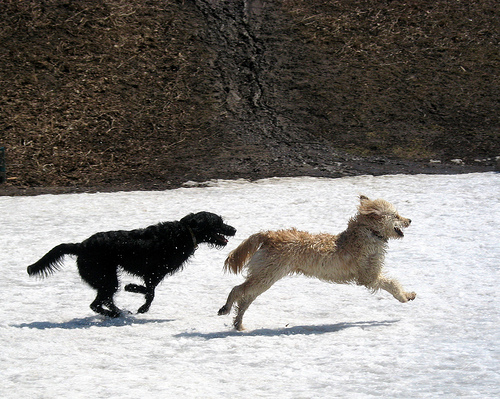

In [277]:
for img_path, caps in train_raw.take(1):
    break
print(img_path)
img = load_img(img_path, caps)
print(img.shape)
caps = [cap.numpy().decode('utf-8') for cap in caps]
print(caps)
Image.open(img_path.numpy().decode('utf-8'))

In [278]:
class GenerateText(tf.keras.callbacks.Callback):
    def __init__(self, img = img):
        #print(img.shape)
        self.image = img[tf.newaxis, ...]
        self.caps = caps

    def on_epoch_end(self, epochs = None, logs = None):
        print('\n')
        for temp in (0, 0.5, 1):
            gen_text = self.model.generate_text(self.image)
            f_val = self.model.f_score(gen_text, self.caps, n_gram_range = 1)
            print(f'Generated_text: {gen_text}, \t f_score: {f_val}')

In [279]:
sample_gen_text = GenerateText()
sample_gen_text.model = captioner_model
sample_gen_text.on_epoch_end(0)



### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
Generated_text: a a a a a a a, 	 f_score: 0
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
Generated_text: green young a, 	 f_score: 0
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
Generated_text: a the a a a, 	 f_score: 0


In [280]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
callbacks = [GenerateText(),
             tf.keras.callbacks.EarlyStopping(patience = 6, restore_best_weights = True)]

In [281]:
captioner_model.compile(loss = masked_loss, optimizer = optimizer, metrics = [masked_accuracy])

In [282]:
hist = captioner_model.fit(
    train_ds.repeat(),
    steps_per_epoch = 100,
    validation_data = test_ds.repeat(),
    validation_steps = 20,
    epochs = 100,
    callbacks = callbacks
)

Epoch 1/100
### (None, 10, 5, 576)
### 576
### (None, 10, 5, 576)
### 576
100/100 [==============================] - ETA: 0s - loss: 5.0515 - masked_accuracy: 0.1622### (None, 10, 5, 576)
### 576


### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
Generated_text: a, 	 f_score: 0
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
Generated_text: a person, 	 f_score: 0
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
Generated_text: a, 	 f_score: 0
100/100 [==============================] - 17s 135ms/step - loss: 5.0515 - masked_accuracy: 0.1622 - val_loss: 4.8499 - val_masked_accuracy: 0.1986
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 4.7910 - masked_accuracy: 0.2021

### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 576
### (1, 10, 5, 576)
### 57

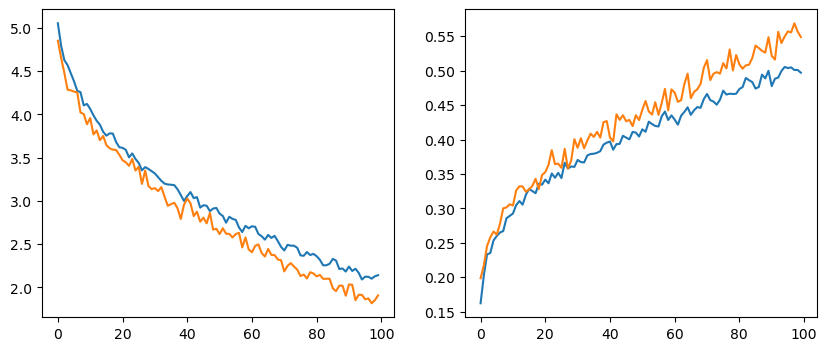

In [283]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['masked_accuracy'], label = 'masked_accuracy')
plt.plot(hist.history['val_masked_accuracy'], label = 'val_masked_accuracy')
plt.show()

In [284]:
def display_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, image_shape[:-1])
    return img

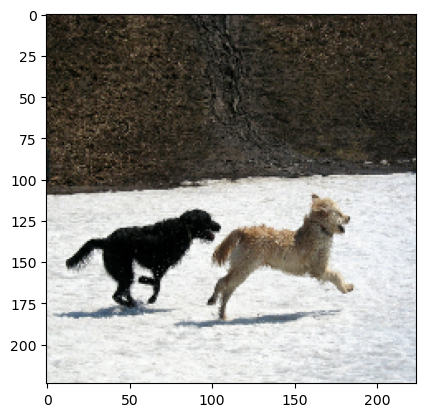

### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
Generated Caption: two white dogs run through the snow


In [285]:
for img_path, caps in train_raw.batch(4).take(1):
    #print()
    break

img = display_img(img_path[0].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

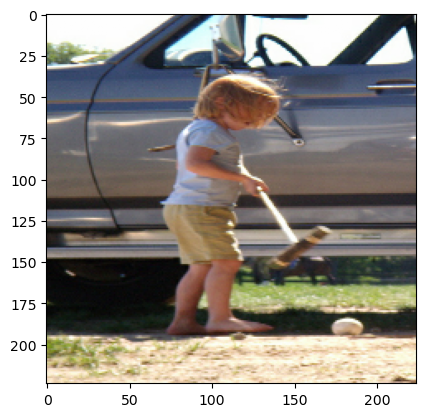

### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
Generated Caption: the young child is standing on the camera near the camera


In [286]:
#print(img_path[1].numpy().decode('utf-8'))
img = display_img(img_path[1].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

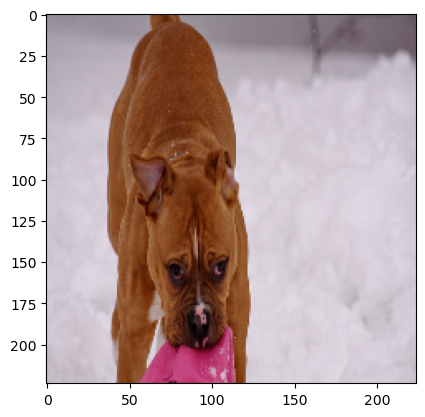

### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
Generated Caption: a large brown dog in a red collar on a red toy


In [287]:
img = display_img(img_path[2].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

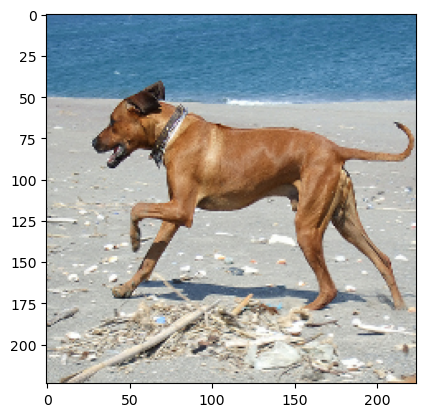

### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
Generated Caption: a brown dog is running in the water


In [288]:
img = display_img(img_path[3].numpy().decode('utf-8'))
plt.imshow(img/255.0)
plt.show()
print(f'Generated Caption: {captioner_model.generate_text(img[tf.newaxis, ...])}')

### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576


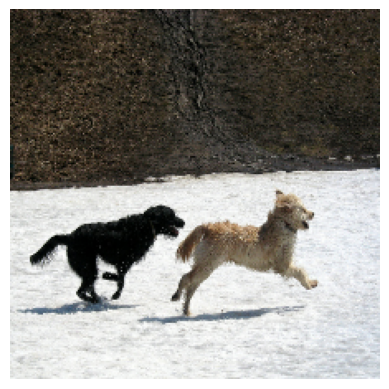

three dogs play in the snow


In [289]:
for img_path, cap in train_raw.take(1):
    break
img = display_img(img_path)
cap_gen = captioner_model.generate_text(img[tf.newaxis, ...])

plt.imshow(img/255)
plt.axis('off')
plt.show()
print(cap_gen)

In [290]:
cap_gen_tokens = cap_gen.split() + ['[END]']
print(len(cap_gen_tokens))

7


In [291]:
attn_scores = captioner_model.decoder.last_attention_scores
print(attn_scores.shape)
attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')
print(attn_maps.shape)

(1, 2, 7, 49)
(7, 7, 7)


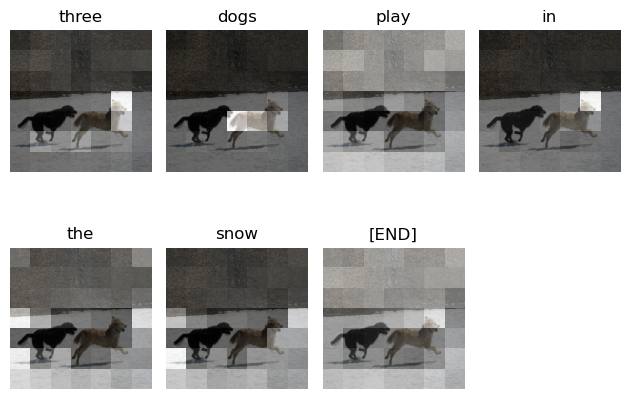

In [292]:
len_result = len(attn_maps)
col_len = int(np.ceil(len_result/2))
row_len = 2

for i in range(len_result):
    ax = plt.subplot(row_len, col_len, i+1)
    img_plot = ax.imshow(img/255)
    plt.title(cap_gen_tokens[i])
    ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [293]:
@Captioner.add_method
def show_attention(self, img, temperature = 0.5):
    gen_text = self.generate_text(img = img[tf.newaxis, ...], temperature = temperature)
    cap_gen_tokens = cap_gen.split() + ['[END]']
    # Here we are adding [END] token as while printing text using id_to_text, it filters out [END] token even though it is generated.
    attn_scores = captioner_model.decoder.last_attention_scores
    attn_maps = einops.reduce(attn_scores, 'b num_heads seq_len (h w) -> seq_len h w', h = 7, w = 7, reduction = 'mean')

    len_result = len(attn_maps)
    col_len = int(np.ceil(len_result/2))
    row_len = 2

    for i in range(len_result):
        ax = plt.subplot(row_len, col_len, i+1)
        img_plot = ax.imshow(img/255)
        plt.title(cap_gen_tokens[i])
        ax.imshow(attn_maps[i], cmap = 'gray', alpha = 0.6, extent = img_plot.get_extent(), clim = [0, np.max(attn_maps[i])])
        plt.axis('off')

### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576
### (1, 7, 7, 576)
### 576


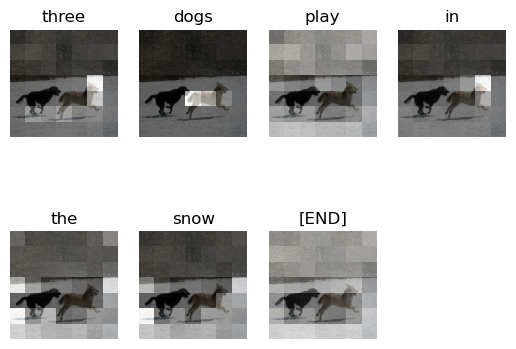

In [294]:
captioner_model.show_attention(img)